# Projeto Final: Análise de Sentimentos usando avaliações coletadas de curso da plataforma "Coursera"

Disciplina: Processamento de Linguagem Natural

Professores: Luciano Barbosa / Johny Moreira 

Aluno: Laureano Montarroyos Fo

Especialização Deep Learning - Turma 2022/2023

Cin.AI - UFPE

.Fonte de Dados: coletou-se dados de avaliações feitas para o curso "Sequence Models", capacitação que faz parte da especialização em Deep Learning da plataforma on-line de cursos da "Coursera", cujo endereço é o "https://www.coursera.org/learn/nlp-sequence-models". Foram capturadas 6467 avaliações em 21/03/2023 por um programa elaborado em python, fazendo uso da biblioteca "Scrapy", a partir do endereço "https://www.coursera.org/learn/nlp-sequence-models/reviews?page=1".

In [ ]:
# bibliotecas básicas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import spacy #pip install spacy

In [ ]:
# Configurando tamanho das imagens
rcParams['figure.figsize'] = 9, 3

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Disciplinas/Processamento de Linguagem Natural/Projeto


!ls

/content/gdrive/MyDrive/Disciplinas/Processamento de Linguagem Natural/Projeto
coursera-processado.csv		       PLN-Bert.ipynb
coursera-processado-segunda-parte.csv  PLN-SVM02.ipynb


# Pré-processamento do aquivo CSV com dados coletados da plataforma da "Coursera"

In [ ]:
df = pd.read_csv("coursera.csv")
df.shape

(6467, 3)

In [ ]:
df.head()

,indice,estrelas,comentario
0,1,Filled Star:Star:Star:Star:Star:,"Tons of editing errors in lectures, and the pr..."
1,2,Filled Star:Filled Star:Star:Star:Star:,This course is by far the weakest out of the 5...
2,3,Filled Star:Star:Star:Star:Star:,Full of appalling errors that have been presen...
3,4,Filled Star:Filled Star:Filled Star:Star:Star:,I really like the deeplearning.ai specializati...
4,5,Filled Star:Filled Star:Star:Star:Star:,The lectures were great. Andrew is a wonderful...


Função para criar coluna com contagem do número de estrelas atribuídas pelo usuário ao realizar comentário no site sobre o curso. A marcação "Filled Star" indica a atribuição de estrela, simbolizando a imagem preenchida com cor. Por outro lado, a marca "Star" simboliza estrela não preenchida e sem cor.


In [ ]:
def contaEstrelas(estrelas):
  pontos = 0
  if(estrelas!=''):
    lista = estrelas.split(':')
    for item in lista:
      if(item=='Filled Star'):
        pontos+=1
  return pontos

df['qtd_estrelas'] = df.estrelas.apply(contaEstrelas)
df.head()

,indice,estrelas,comentario,qtd_estrelas
0,1,Filled Star:Star:Star:Star:Star:,"Tons of editing errors in lectures, and the pr...",1
1,2,Filled Star:Filled Star:Star:Star:Star:,This course is by far the weakest out of the 5...,2
2,3,Filled Star:Star:Star:Star:Star:,Full of appalling errors that have been presen...,1
3,4,Filled Star:Filled Star:Filled Star:Star:Star:,I really like the deeplearning.ai specializati...,3
4,5,Filled Star:Filled Star:Star:Star:Star:,The lectures were great. Andrew is a wonderful...,2


Examinando a distribuição da quantidade de estrelas para averiguar a possibilidade de agregar as avaliações em apenas duas categorias, caso os conteúdos façam sentido, de maneira a não distorcer o significado que se pretende aferir pelo treinamento.

In [ ]:
(df.groupby('qtd_estrelas').count())

,indice,estrelas,comentario
qtd_estrelas,,,
1,45,45,45
2,81,81,81
3,396,396,396
4,1131,1131,1131
5,4814,4814,4814


In [ ]:
print(df[df['qtd_estrelas']==3][['comentario','indice']])

                                             comentario  indice
3     I really like the deeplearning.ai specializati...       4
11    5 stars for the very informative lectures.  I ...      12
75    The first week is amazing. The last week is th...      76
76    Week 4 coding exercise is incomparably harder ...      77
3148  in comparison to the previous courses from thi...    3149
...                                                 ...     ...
6462  Overall a great class. I had some trouble unde...    6463
6463  This felt the the least prepared and organized...    6464
6464  give projects that we can build from ground up...    6465
6465  Good theoretical overview - project just requi...    6466
6466  Lectures on week4 are not complete as confirme...    6467

[396 rows x 2 columns]


In [ ]:
df[df['indice']==4]['comentario'].tolist()

['I really like the deeplearning.ai specialization. And also I like the Sequence Models course. However, I feel that I have learned less during this course comparing to the other ones in the specialization. First, I believe it was an extensive use of Keras. Whereas the framework is great, it would be much better for understanding if all the exercises were in numpy, whereas Keras tween-projects be optional.  Doing both numpy and Keras versions would allow to better understand the material and learn through repetition. Second, even though the course is great, I perceived the number of errors/typos was much higher than in other courses. Is that true? For example, the Jazz Improvisation exercise was a nightmare. Overall, thank you for the course. Despite those problems, I would still recommend it.']

In [ ]:
df[df['indice']==6467]['comentario'].tolist()

['Lectures on week4 are not complete as confirmed by mentor in the community']

Função para criar coluna que junta as avaliações das revisões em dois grupos: "0" para uma avaliação ruim, agregando as revisões de 1 a 3 estrelas e "1" para uma avaliação boa, agregando as revisões com 4 e 5 estrelas.



In [ ]:
avaliacoes_rotulos = ['ruim','boa']

In [ ]:
def classifica_revisao_em_boa_ou_ruim(estrelas):
  avaliacao = 0
  if estrelas > 3:
    avaliacao = 1
  return avaliacao

df['avaliacao'] = df.qtd_estrelas.apply(classifica_revisao_em_boa_ou_ruim)

print('A base possui um total de {} registros. Os 10 primeiros são:'.format(len(df)))
df.head(10)

A base possui um total de 6467 registros. Os 10 primeiros são:


,indice,estrelas,comentario,qtd_estrelas,avaliacao
0,1,Filled Star:Star:Star:Star:Star:,"Tons of editing errors in lectures, and the pr...",1,0
1,2,Filled Star:Filled Star:Star:Star:Star:,This course is by far the weakest out of the 5...,2,0
2,3,Filled Star:Star:Star:Star:Star:,Full of appalling errors that have been presen...,1,0
3,4,Filled Star:Filled Star:Filled Star:Star:Star:,I really like the deeplearning.ai specializati...,3,0
4,5,Filled Star:Filled Star:Star:Star:Star:,The lectures were great. Andrew is a wonderful...,2,0
5,6,Filled Star:Star:Star:Star:Star:,Keras is required to pass the assignments but ...,1,0
6,7,Filled Star:Filled Star:Filled Star:Filled Sta...,"To set the context, I have a PhD in Computer E...",5,1
7,8,Filled Star:Filled Star:Filled Star:Filled Sta...,I am so grateful that Andrew and the team prov...,5,1
8,9,Filled Star:Filled Star:Filled Star:Filled Sta...,I want to thank Andrew Ng and his team for the...,5,1
9,10,Filled Star:Filled Star:Star:Star:Star:,I went through all course of DeepLearning.ai S...,2,0


In [ ]:
(df.groupby('avaliacao').count())

,indice,estrelas,comentario,qtd_estrelas
avaliacao,,,,
0,522,522,522,522
1,5945,5945,5945,5945


Função para criar coluna com tamanho do comentário a fim de ajudar na definição do tamanho máximo a ser considerado no treinamento do modelo.

In [ ]:
def Registra_tamanho_do_comentario(comentario):
  #l1 = comentario.tolist()
  return len(comentario)

df['tamanho_comentario'] = df.comentario.apply(Registra_tamanho_do_comentario)

print('A base possui um total de {} registros. Os 10 primeiros são:'.format(len(df)))
df.head(10)

A base possui um total de 6467 registros. Os 10 primeiros são:


,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
0,1,Filled Star:Star:Star:Star:Star:,"Tons of editing errors in lectures, and the pr...",1,0,249
1,2,Filled Star:Filled Star:Star:Star:Star:,This course is by far the weakest out of the 5...,2,0,645
2,3,Filled Star:Star:Star:Star:Star:,Full of appalling errors that have been presen...,1,0,419
3,4,Filled Star:Filled Star:Filled Star:Star:Star:,I really like the deeplearning.ai specializati...,3,0,802
4,5,Filled Star:Filled Star:Star:Star:Star:,The lectures were great. Andrew is a wonderful...,2,0,835
5,6,Filled Star:Star:Star:Star:Star:,Keras is required to pass the assignments but ...,1,0,160
6,7,Filled Star:Filled Star:Filled Star:Filled Sta...,"To set the context, I have a PhD in Computer E...",5,1,264
7,8,Filled Star:Filled Star:Filled Star:Filled Sta...,I am so grateful that Andrew and the team prov...,5,1,199
8,9,Filled Star:Filled Star:Filled Star:Filled Sta...,I want to thank Andrew Ng and his team for the...,5,1,155
9,10,Filled Star:Filled Star:Star:Star:Star:,I went through all course of DeepLearning.ai S...,2,0,365


In [ ]:
df[df['indice']==6467]

,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
6466,6467,Filled Star:Filled Star:Filled Star:Star:Star:,Lectures on week4 are not complete as confirme...,3,0,74


Analisando o tamanho dos comentários a fim de definir um tamanho máximo para ser usado no treinamento

In [ ]:
# Tamanho do maior comentário
df['tamanho_comentario'].max()

1904

In [ ]:
df['tamanho_comentario'].describe()

count    6467.000000
mean      110.552807
std       124.203054
min         1.000000
25%        31.000000
50%        73.000000
75%       146.000000
max      1904.000000
Name: tamanho_comentario, dtype: float64

In [ ]:
df[df['tamanho_comentario']>500]['tamanho_comentario'].count()

88

In [ ]:
df[df['tamanho_comentario']>1000]['tamanho_comentario'].count()

7

In [ ]:
max_sent_length = 500

In [ ]:
df.to_csv("coursera-processado.csv", index=False)

In [ ]:
!ls

aulas			  coursera-processado.csv		  PLN01.ipynb
coursera2.csv		  coursera-processado-segunda-parte.csv   PLN02.ipynb
coursera.csv		  coursera-processado-versao-inicial.csv
coursera-processado2.csv  coursera.py


In [ ]:
df = pd.read_csv("coursera-processado.csv")
df.shape

(6467, 6)

In [ ]:
print('A base possui um total de {} registros. Os 10 primeiros são:'.format(len(df)))

df.head(10)

A base possui um total de 6467 registros. Os 10 primeiros são:


,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
0,1,Filled Star:Star:Star:Star:Star:,"Tons of editing errors in lectures, and the pr...",1,0,249
1,2,Filled Star:Filled Star:Star:Star:Star:,This course is by far the weakest out of the 5...,2,0,645
2,3,Filled Star:Star:Star:Star:Star:,Full of appalling errors that have been presen...,1,0,419
3,4,Filled Star:Filled Star:Filled Star:Star:Star:,I really like the deeplearning.ai specializati...,3,0,802
4,5,Filled Star:Filled Star:Star:Star:Star:,The lectures were great. Andrew is a wonderful...,2,0,835
5,6,Filled Star:Star:Star:Star:Star:,Keras is required to pass the assignments but ...,1,0,160
6,7,Filled Star:Filled Star:Filled Star:Filled Sta...,"To set the context, I have a PhD in Computer E...",5,1,264
7,8,Filled Star:Filled Star:Filled Star:Filled Sta...,I am so grateful that Andrew and the team prov...,5,1,199
8,9,Filled Star:Filled Star:Filled Star:Filled Sta...,I want to thank Andrew Ng and his team for the...,5,1,155
9,10,Filled Star:Filled Star:Star:Star:Star:,I went through all course of DeepLearning.ai S...,2,0,365


In [ ]:
df.tail(10)

,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
6457,6458,Filled Star:Filled Star:Filled Star:Star:Star:,Really Nice course. Could have been more fun i...,3,0,90
6458,6459,Filled Star:Filled Star:Filled Star:Star:Star:,Course is got but grader compilations are horr...,3,0,90
6459,6460,Filled Star:Filled Star:Filled Star:Star:Star:,Not as good as structured in explanation nor i...,3,0,88
6460,6461,Filled Star:Filled Star:Filled Star:Star:Star:,"This is only good enough, not good course. All...",3,0,86
6461,6462,Filled Star:Filled Star:Filled Star:Star:Star:,the lab and programming is not as intuitive as...,3,0,85
6462,6463,Filled Star:Filled Star:Filled Star:Star:Star:,Overall a great class. I had some trouble unde...,3,0,84
6463,6464,Filled Star:Filled Star:Filled Star:Star:Star:,This felt the the least prepared and organized...,3,0,84
6464,6465,Filled Star:Filled Star:Filled Star:Star:Star:,give projects that we can build from ground up...,3,0,77
6465,6466,Filled Star:Filled Star:Filled Star:Star:Star:,Good theoretical overview - project just requi...,3,0,77
6466,6467,Filled Star:Filled Star:Filled Star:Star:Star:,Lectures on week4 are not complete as confirme...,3,0,74


# Pré-Processamento dos Dados para ser utilizado por SVM

In [ ]:
# Recuperando a base salva após pré-processamento inicial
df = pd.read_csv("coursera-processado.csv")
df.shape

(6467, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6467 entries, 0 to 6466
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   indice              6467 non-null   int64 
 1   estrelas            6467 non-null   object
 2   comentario          6467 non-null   object
 3   qtd_estrelas        6467 non-null   int64 
 4   avaliacao           6467 non-null   int64 
 5   tamanho_comentario  6467 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 303.3+ KB


In [ ]:
df.head(5)

,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
0,1,Filled Star Star Star Star Star,of in and the rely more on knowledge of essent...,1,0,249
1,2,Filled Star Filled Star Star Star Star,This course is by far the out of the course se...,2,0,645
2,3,Filled Star Star Star Star Star,Full of appalling that have been present for o...,1,0,419
3,4,Filled Star Filled Star Filled Star Star Star,I really like the ai specialization And also I...,3,0,802
4,5,Filled Star Filled Star Star Star Star,The were great is a wonderful teacher but the ...,2,0,835


In [ ]:
# Removendo palavras que não estão na língua inglesa
# !pip install nltk
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

f = lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words)
cols = df.select_dtypes(object).columns
df[cols] = df[cols].applymap(f)
  
df.head(5)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
0,1,Filled Star Star Star Star Star,of in and the rely more on knowledge of essent...,1,0,249
1,2,Filled Star Filled Star Star Star Star,This course is by far the out of the course se...,2,0,645
2,3,Filled Star Star Star Star Star,Full of appalling that have been present for o...,1,0,419
3,4,Filled Star Filled Star Filled Star Star Star,I really like the ai specialization And also I...,3,0,802
4,5,Filled Star Filled Star Star Star Star,The were great is a wonderful teacher but the ...,2,0,835


In [ ]:
# Removendo "Stop Words"
def removing_stop_words_and_ponct(row):
  string_without_ponct = ""
  for i, word in enumerate(nlp(row)):
      if word.is_punct==False and word.is_stop==False:
          string_without_ponct += " "+word.text
  return string_without_ponct

df['comentario'] = df.apply(lambda row : removing_stop_words_and_ponct(row['comentario']), axis = 1)
df.head(5)

,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
0,1,Filled Star Star Star Star Star,rely knowledge essentially untaught course un...,1,0,249
1,2,Filled Star Filled Star Star Star Star,course far course sequence think help build u...,2,0,645
2,3,Filled Star Star Star Star Star,appalling present year clear let trying earn ...,1,0,419
3,4,Filled Star Filled Star Filled Star Star Star,like ai specialization like Sequence course f...,3,0,802
4,5,Filled Star Filled Star Star Star Star,great wonderful teacher miserable notebook pr...,2,0,835


In [ ]:
df=df.dropna(subset=['comentario'])
df['comentario'].isnull().values.any()

False

In [ ]:
# Aplicando "Lemmatization" ao campo de comentários

def lemm(row):
  string_lem = ""
  for word in nlp(row):
      string_lem += " "+ word.lemma_
  return string_lem

df['comentario'] = df.apply(lambda row : lemm(row['comentario']), axis = 1)
df.head(5)

,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
0,1,Filled Star Star Star Star Star,rely knowledge essentially untaught course ...,1,0,249
1,2,Filled Star Filled Star Star Star Star,course far course sequence think help build...,2,0,645
2,3,Filled Star Star Star Star Star,appal present year clear let try earn live ...,1,0,419
3,4,Filled Star Filled Star Filled Star Star Star,like ai specialization like Sequence course...,3,0,802
4,5,Filled Star Filled Star Star Star Star,great wonderful teacher miserable notebook ...,2,0,835


In [ ]:
df=df.dropna(subset=['comentario'])
df['comentario'].isnull().values.any()

False

In [ ]:
max_sent_length = 500

In [ ]:
def Limita_tamanho_do_comentario(texto):
  tamanho = len(texto)
  if(tamanho > max_sent_length):
    texto = texto[0:499] 
  return texto

df['comentario'] = df.comentario.apply(Limita_tamanho_do_comentario)

print('A base possui um total de {} registros. Os 10 primeiros são:'.format(len(df)))
df.head(10)

A base possui um total de 6270 registros. Os 10 primeiros são:


,indice,estrelas,comentario,qtd_estrelas,avaliacao,tamanho_comentario
0,1,Filled Star Star Star Star Star,rely knowledge essentially untaught course ...,1,0,249
1,2,Filled Star Filled Star Star Star Star,course far course sequence think help build...,2,0,645
2,3,Filled Star Star Star Star Star,appal present year clear let try earn live ...,1,0,419
3,4,Filled Star Filled Star Filled Star Star Star,like ai specialization like Sequence course...,3,0,802
4,5,Filled Star Filled Star Star Star Star,great wonderful teacher miserable notebook ...,2,0,835
5,6,Filled Star Star Star Star Star,pass training provide learn course question...,1,0,160
6,7,Filled Star Filled Star Filled Star Filled Sta...,set context Computer Engineering University...,5,1,264
7,8,Filled Star Filled Star Filled Star Filled Sta...,grateful team provide good course learn cou...,5,1,199
8,9,Filled Star Filled Star Filled Star Filled Sta...,want thank team amazing work definitely wor...,5,1,155
9,10,Filled Star Filled Star Star Star Star,go course ai Specialization happy specializ...,2,0,365


In [ ]:
df.to_csv("coursera-processado-para-SVM.csv", index=False)

In [ ]:
!ls

aulas				       coursera-processado-versao-inicial.csv
coursera2.csv			       coursera.py
coursera.csv			       PLN01.ipynb
coursera-processado2.csv	       PLN02.ipynb
coursera-processado.csv		       saved_model
coursera-processado-para-SVM.csv       saved_model-primeiro-teste
coursera-processado-segunda-parte.csv


# Recuperando Dados processados para uso do SVM

In [ ]:
# Recuperando a base salva
df = pd.read_csv("coursera-processado-para-SVM.csv")
df.shape

(6270, 6)

In [ ]:
data = df[['comentario','avaliacao']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6270 entries, 0 to 6269
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comentario  6270 non-null   object
 1   avaliacao   6270 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 98.1+ KB


In [ ]:
X = data['comentario']
y = data['avaliacao']

avaliacoes_rotulos = ['ruim','boa']
max_sent_length = 500

In [ ]:
# Separação dos dados em conjuntos de treinamento e teste
from sklearn.model_selection import train_test_split
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=SEED, test_size=0.25)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4702,)
(4702,)
(1568,)
(1568,)


# modelos SVM usando BOW, TF-IDF e Embeddings

## SVM com dado vetorizado usando Bag of Words (BOW)

In [ ]:
# Vetorizando tanto os dados de treinamento quanto os de teste
vectorizer = CountVectorizer()    # BOW

X_train_tfidf_vectorize = vectorizer.fit_transform(X_train)
X_test_tfidf_vectorize = vectorizer.transform(X_test)

Verificando que por ter utilizado no conjunto de testes a mesma transformação  que foi
 ajustada ao conjunto de treinamento, o número de features(colunas) permanece o mesmo
em ambos os conjuntos.

In [ ]:
X_train_tfidf_vectorize.shape

(4702, 2088)

In [ ]:
X_test_tfidf_vectorize.shape

(1568, 2088)

SVM LINEAR - usando abordagem mais simples, antes de fazer uso do SVM não linear

In [ ]:
cls = svm.SVC(kernel="linear",C=0.05)

cls.fit(X_train_tfidf_vectorize, y_train)

pred = cls.predict(X_test_tfidf_vectorize)

print("Acurária no conj. de teste = ", cls.score(X_test_tfidf_vectorize, y_test))

print("Acurária no conj. de treino = ",cls.score(X_train_tfidf_vectorize, y_train))

Acurária no conj. de teste =  0.9215561224489796
Acurária no conj. de treino =  0.9300297745640154


Em relação às métricas de avaliação, é possível constatar que, embora o modelo tenha alcançado uma boa acurácia, ele não consegue ter um bom F1-score para a classe "ruim". Há mais instâncias de avaliação "boa" do que "ruim" e isso está indesejadamente
refletindo no treinamento e desempenho do modelo final. A matriz de confusão mais abaixo deixa isso ainda mais claro. O modelo apresenta tendência para classificar como "boa" a avaliação de todo comentário durante os testes realizados.

In [ ]:
print(metrics.classification_report(y_test, pred, target_names=avaliacoes_rotulos))
print(avaliacoes_rotulos)
print(cls.classes_)

              precision    recall  f1-score   support

        ruim       1.00      0.04      0.08       128
         boa       0.92      1.00      0.96      1440

    accuracy                           0.92      1568
   macro avg       0.96      0.52      0.52      1568
weighted avg       0.93      0.92      0.89      1568

['ruim', 'boa']
[0 1]


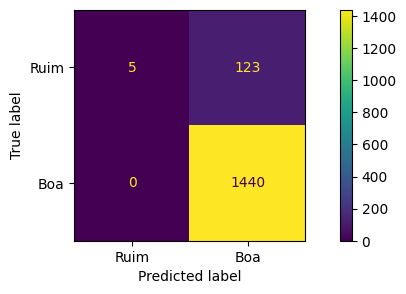

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ruim", "Boa"])
disp.plot()
plt.show()

SVM NÃO LINEAR - fazendo uso da variação não linear do SVM para avaliar se há ganho nos resultados,
comparativamente à sua versão linear usada anteriormente.

In [ ]:

cls = svm.SVC(kernel="rbf",C=2,gamma=0.01) 

cls.fit(X_train_tfidf_vectorize, y_train)

pred = cls.predict(X_test_tfidf_vectorize)

print("Acurária no conj. de teste = ", cls.score(X_test_tfidf_vectorize, y_test))

print("Acurária no conj. de treino = ",cls.score(X_train_tfidf_vectorize, y_train))

Acurária no conj. de teste =  0.9209183673469388
Acurária no conj. de treino =  0.9274776690769885


Em relação às métricas de avaliação, é possível constatar que, embora o modelo não linear tenha alcançado uma acurácia tão boa quanto sua variação linear, ele também não consegue ter um bom F1-score para a classe "ruim". A exemplo do que já se destacou na análise do SVM linear, o desbalanceamento dos dados de treinamento repercute negativamente no desempenho do modelo final. Novamente,a matriz de confusão mais abaixo deixa isso claro. O cenário se repete com o modelo apresentando tendência para classificar como "boa" a avaliação de todo comentário durante os testes realizados.

In [ ]:
print(metrics.classification_report(y_test, pred, target_names=avaliacoes_rotulos))
print(avaliacoes_rotulos)
print(cls.classes_)

              precision    recall  f1-score   support

        ruim       1.00      0.03      0.06       128
         boa       0.92      1.00      0.96      1440

    accuracy                           0.92      1568
   macro avg       0.96      0.52      0.51      1568
weighted avg       0.93      0.92      0.89      1568

['ruim', 'boa']
[0 1]


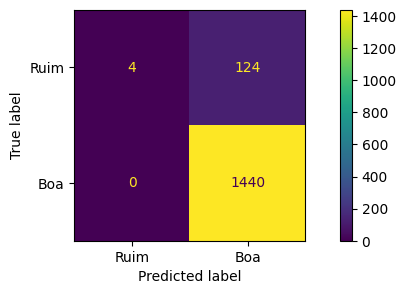

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ruim", "Boa"])
disp.plot()
plt.show()

## SVM com dado vetorizado usando TF-IDF

A opção por usar também o TF-IDF é apenas para avaliar se há algum ganho significativo para a análise pretendida em relação ao Bag of Words, hipótese rejeitada mais a frente com base nas métricas alcançadas.

In [ ]:
# Vetorizando tanto os dados de treinamento quanto os de teste
vectorizer = TfidfVectorizer()    # tf-idf

X_train_tfidf_vectorize = vectorizer.fit_transform(X_train)
X_test_tfidf_vectorize = vectorizer.transform(X_test)

SVM LINEAR - usando abordagem mais simples, antes de fazer uso do SVM não linear

In [ ]:
# SVM LINEAR

cls = svm.SVC(kernel="linear",C=0.05)

cls.fit(X_train_tfidf_vectorize, y_train)

pred = cls.predict(X_test_tfidf_vectorize)

print("Acurária no conj. de teste = ", cls.score(X_test_tfidf_vectorize, y_test))

print("Acurária no conj. de treino = ",cls.score(X_train_tfidf_vectorize, y_train))

Acurária no conj. de teste =  0.9183673469387755
Acurária no conj. de treino =  0.9183326244151425


Em relação às métricas de avaliação, é possível constatar que o modelo alcançou uma acurácia tão boa quanto às opçoes anteriores testadas com "Bag of Words". Entretanto, a técnica repete a mesma dificuldade das variações passadas ao também não conseguir um bom F1-score para a classe "ruim". Na realidade, consegue ser pior e apresenta problemas para o seu cálculo, o que fica evidenciado na matriz de confusão mais abaixo em que se visualiza que o modelo não acertou nenhuma previsão para a classe "ruim" nos testes realizados, classificando todas as avaliações de comentários como "boa".

In [ ]:
print(metrics.classification_report(y_test, pred, target_names=avaliacoes_rotulos))
print(avaliacoes_rotulos)
print(cls.classes_)

              precision    recall  f1-score   support

        ruim       0.00      0.00      0.00       128
         boa       0.92      1.00      0.96      1440

    accuracy                           0.92      1568
   macro avg       0.46      0.50      0.48      1568
weighted avg       0.84      0.92      0.88      1568

['ruim', 'boa']
[0 1]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


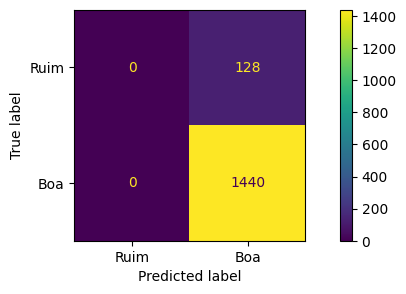

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ruim", "Boa"])
disp.plot()
plt.show()

SVM NÃO LINEAR - fazendo uso da variação não linear do SVM para avaliar se há ganho nos resultados,
comparativamente à sua versão linear usada anteriormente.

In [ ]:
# SVM NÃO LINEAR

cls = svm.SVC(kernel="rbf",C=2,gamma=0.01)   

cls.fit(X_train_tfidf_vectorize, y_train)

pred = cls.predict(X_test_tfidf_vectorize)

print("Acurária no conj. de teste = ", cls.score(X_test_tfidf_vectorize, y_test))

print("Acurária no conj. de treino = ",cls.score(X_train_tfidf_vectorize, y_train))

Acurária no conj. de teste =  0.9183673469387755
Acurária no conj. de treino =  0.9183326244151425


Em relação às métricas de avaliação, é possível constatar que, uma vez mais, o modelo alcançou uma acurácia tão boa quanto às opçoes anteriores testadas com "Bag of Words" e ainda sua variação linear com TF-IDF. Entretanto, a técnica repete a mesma dificuldade das variações passadas ao também não conseguir um bom F1-score para a classe "ruim". Na realidade, assim como há havia acontecido com a variante linear, consegue ser pior e apresenta o mesmo problema para o seu cálculo, o que fica evidenciado na matriz de confusão mais abaixo em que se visualiza que o modelo também não acertou nenhuma previsão para a classe "ruim" nos testes realizados, classificando todas as avaliações de comentários como "boa".

In [ ]:
print(metrics.classification_report(y_test, pred, target_names=avaliacoes_rotulos))
print(avaliacoes_rotulos)
print(cls.classes_)

              precision    recall  f1-score   support

        ruim       0.00      0.00      0.00       128
         boa       0.92      1.00      0.96      1440

    accuracy                           0.92      1568
   macro avg       0.46      0.50      0.48      1568
weighted avg       0.84      0.92      0.88      1568

['ruim', 'boa']
[0 1]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


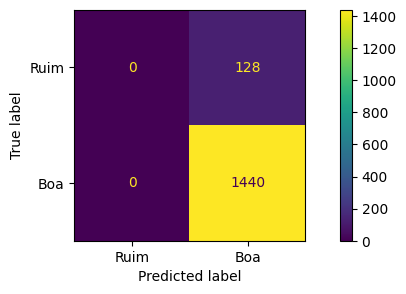

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ruim", "Boa"])
disp.plot()
plt.show()

## SVM com dado vetorizado usando Embeddings

Na abordagem fazendo uso de "embeddings", optou-se por usar o "Word2Vec" pré-treinado da biblioteca "Gensim", com auxílio da biblioteca "nltk" para geração dos "tokens" e processamento de texto.

In [ ]:
# Pré-processamento textual para gerar tokens antes de treinar o modelo Word2Vec
import nltk
from nltk.tokenize import word_tokenize
# tokenizador de sentença do nltk
nltk.download('punkt')

tokenized_sents = [word_tokenize(i) for i in data['comentario'].values]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Treinando modelo Word2Vec com sentenças tokenizadas no passo anterior
from gensim.models import Word2Vec

model_comentario = Word2Vec(tokenized_sents, vector_size=50, window=5, min_count=1, workers=4)

In [ ]:
# Exemplo dos vetores de embeddings gerados para o token "rely" presente no vocabulário
model_comentario.wv['rely']

array([ 0.03978902, -0.00631488, -0.0165826 ,  0.00178005,  0.04223435,
       -0.05384026,  0.06279373,  0.09568366, -0.02574416,  0.01439488,
        0.05472324, -0.07952483,  0.0703565 ,  0.03360213, -0.02223076,
        0.02508537,  0.03957639,  0.04465064, -0.11242937, -0.02293733,
        0.01466952,  0.01189443,  0.06340218, -0.00346899,  0.02774817,
        0.03772026, -0.05158338,  0.00298197, -0.08064382, -0.03049918,
        0.00142822,  0.02936568, -0.02782115,  0.00926813, -0.07451983,
        0.05873785,  0.03201521,  0.01119602,  0.00799263, -0.08095308,
        0.0683801 , -0.03235258, -0.00373098,  0.03029613,  0.07838054,
        0.00150612,  0.001771  , -0.07187025,  0.00528144,  0.02726002],
      dtype=float32)

In [ ]:
# Exemplo dos vetores de embeddings gerados para o token "video" presente no vocabulário
model_comentario.wv['video']

array([ 2.46482968e-01, -1.03480347e-01, -9.21995193e-02,  2.26948988e-02,
        3.04817140e-01, -4.61056978e-01,  8.73234332e-01,  1.20886052e+00,
       -3.27119708e-01,  8.13514888e-02,  7.59196460e-01, -1.06637859e+00,
        8.79099250e-01,  5.71853697e-01, -2.40989268e-01,  3.28515083e-01,
        3.19796860e-01,  5.68355918e-01, -1.44541633e+00, -1.61572039e-01,
        8.63271803e-02,  3.41107771e-02,  7.24699497e-01, -2.33176738e-01,
        4.59990025e-01,  3.23353291e-01, -4.47973073e-01,  4.01373807e-04,
       -9.27041113e-01, -2.42229417e-01,  4.13841568e-02,  1.49718165e-01,
       -3.70523870e-01,  2.12234482e-01, -7.37926006e-01,  5.95856845e-01,
        4.72915709e-01,  3.44831795e-01, -1.03719145e-01, -9.80709076e-01,
        9.19544995e-01, -3.30320805e-01,  3.59465890e-02,  3.60628605e-01,
        9.25297797e-01, -1.73912138e-01,  2.06749558e-01, -6.08691812e-01,
        1.51619464e-01,  1.60182461e-01], dtype=float32)

In [ ]:
# Remontando as sentenças dos comentários da base a partir da junção das matrizes correspondentes a cada token
X, y = [], []
max_len = 0

for i, row in data.iterrows():
  vetores = model_comentario.wv[word_tokenize(row['comentario'])]

  max_len = max(max_len, len(vetores))
  X.append(vetores)
  y.append(row['avaliacao'])

print("max_len: {}".format(max_len))

max_len: 71


In [ ]:
# Como as sentenças tem diferentes tamanhos, faz-se uso de padding para padronizar o tamanho 
# usando como referência o maior tamanho, registrado no passo anterior em "max_len".

def transform(exemplos, dimension):
  results = np.zeros((len(exemplos), dimension, 50))
  for i, sequence in enumerate(exemplos):
    results[i, :len(sequence), :] = sequence
  return results
 
X = transform(X, max_len)
y = np.array(y).astype("int64")

In [ ]:
# As senteças tem no máximo 71 tokens, cada qual codificado com embeddings de tamanho 50
X.shape

(6270, 71, 50)

In [ ]:
# Para uso no SVM, é preciso juntar as duas dimensões superiores em uma só por meio do comando "reshape"
X = X.reshape(-1, X.shape[1] * X.shape[2])

In [ ]:
X.shape

(6270, 3550)

In [ ]:
# Separação dos dados para treinamento e teste, sendo 25% para este último.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

SVM LINEAR - usando abordagem mais simples, antes de fazer uso do SVM não linear



In [ ]:
# SVM LINEAR

cls = svm.SVC(kernel="linear",C=0.05)

cls.fit(X_train, y_train)

pred = cls.predict(X_test)

print("Acurária no conj. de teste = ", cls.score(X_test, y_test))

print("Acurária no conj. de treino = ",cls.score(X_train, y_train))

Acurária no conj. de teste =  0.9190051020408163
Acurária no conj. de treino =  0.9198213526159081


Em relação às métricas de avaliação, é possível constatar que a exemplo das variações anteriores, o modelo alcança uma boa acurácia, porém sua fragilidade fica clara quando se observa o baixo F1-score para a classe "ruim". O desbalanceamento dos dados de treinamento também está presente repercutinido negativamente no desempenho do modelo final. A matriz de confusão mais abaixo deixa claro que o modelo tende a apresentat como resultado da previsão a classe "boa" durante os testes realizados.

In [ ]:
print(metrics.classification_report(y_test, pred, target_names=avaliacoes_rotulos))
print(avaliacoes_rotulos)
print(cls.classes_)

              precision    recall  f1-score   support

        ruim       0.67      0.02      0.03       128
         boa       0.92      1.00      0.96      1440

    accuracy                           0.92      1568
   macro avg       0.79      0.51      0.49      1568
weighted avg       0.90      0.92      0.88      1568

['ruim', 'boa']
[0 1]


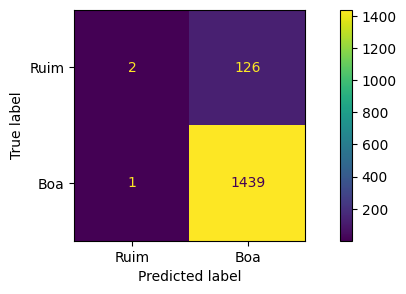

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ruim", "Boa"])
disp.plot()
plt.show()

SVM NÃO LINEAR - fazendo uso da variação não linear do SVM para avaliar se há ganho nos resultados,
comparativamente à sua versão linear usada anteriormente.

In [ ]:
# SVM NÃO LINEAR

#create a classifier
cls = svm.SVC(kernel="rbf",C=2,gamma=0.01)   # testar também com gamma=0.1
#train the model
cls.fit(X_train, y_train)
#predict the response
pred = cls.predict(X_test)

# Acurácia no conj. de teste
print("Acurária no conj. de teste = ", cls.score(X_test, y_test))
# Acurácia no conj. de treinamento
print("Acurária no conj. de treino = ",cls.score(X_train, y_train))

Acurária no conj. de teste =  0.9215561224489796
Acurária no conj. de treino =  0.9257762654189706


Em relação às métricas de avaliação, a situação se repete no modelo não linear, ainda que se esteja utilizando "embeddings".O modelo alcança uma boa acurácia, disfarçando, aparentemente, a fragilidade do modelo até que se observa seu baixo F1-score para a classe "ruim", desta feita similar ao melhor nível observado quando da utilização do "bag of words". O desbalanceamento dos dados de treinamento, mais uma vez, está presente repercutinido negativamente no desempenho do modelo final. A matriz de confusão mais abaixo deixa claro que o modelo tende a apresentar como resultado da previsão a classe "boa" durante os testes realizados.

In [ ]:
print(metrics.classification_report(y_test, pred, target_names=avaliacoes_rotulos))
print(avaliacoes_rotulos)
print(cls.classes_)

              precision    recall  f1-score   support

        ruim       1.00      0.04      0.08       128
         boa       0.92      1.00      0.96      1440

    accuracy                           0.92      1568
   macro avg       0.96      0.52      0.52      1568
weighted avg       0.93      0.92      0.89      1568

['ruim', 'boa']
[0 1]


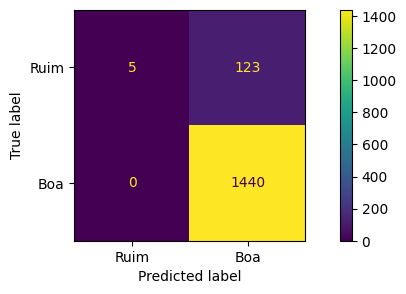

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ruim", "Boa"])
disp.plot()
plt.show()